In [182]:
from __future__ import division

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Problem 1:
Write a function that implements the 1-nearest neighbor classifier with Euclidean distance.
Your function should take as input a matrix of training feature vectors X and a vector of the
corresponding labels Y, as well as a matrix of test feature vectors test. The output should be a
vector of predicted labels preds for all the test points. Naturally, you should not use (or look at the
source code for) any library functions for computing Euclidean distances, nearest neighbor queries,
and so on. If in doubt about what is okay to use, just ask.

Instead of using your 1-NN code directly with data and labels as the training data, do the
following. For each value n ∈ {1000, 2000, 4000, 8000},
 - Draw n random points from data, together with their corresponding labels. In Python, use sel = random.sample(xrange(60000),n)
(after import random), ocr['data'][sel], and ocr['labels'][sel].
 - Use these n points as the training data and testdata as the test points, and compute the
test error rate of the 1-NN classifier.

A plot of the error rate (on the y-axis) as a function of n (on the x-axis) is called a learning curve.
We get an estimate of this curve by using the test error rate in place of the (true) error rate.
Since the above process involves some randomness, you should repeat it independently several
times (say, at least ten times). Produce an estimate of the learning curve plot using the average of
these test error rates (that is, averaging over the repeated trials). Add error bars to your plot that
extend to one standard deviation above and below the means. Ensure the plot axes are properly
labeled. Submit the plot and your source code.

In [3]:
from scipy.spatial.distance import pdist, cdist, squareform, euclidean
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
import random

In [5]:
from scipy.io import loadmat
ocr = loadmat('./data/ocr.mat')

In [6]:
testdata = ocr['testdata']
testlabels = ocr['testlabels']

In [7]:
def print_image(X):
    plt.imshow(X.reshape((28, 28)), cmap=cm.gray_r )
    plt.show()

In [11]:
def compute_distances(x, Y):
    """ Computes the euclidian ditances between a test vector 
    and list of training vectors 
    """
    return np.sqrt(((x-Y)**2).sum(axis=1))

In [159]:
def generate_training_data(sample_size, collection_size):
    collection = []
    for sample in range(collection_size):
        sel = random.sample(xrange(60000), sample_size) 
        data = ocr['data'][sel]
        labels = ocr['labels'][sel]
        collection.append({'data':data, 'labels':labels})
    
    return collection

In [160]:
def compute_error_rates(sample_size):
    actual = [lab[0] for lab in testlabels]
    error_rates = []
    for training in generate_training_data(sample_size, 10):
        trainingdata = training['data']
        traininglabels = training['labels']
        preds = nearest_neighbors(testdata, trainingdata, traininglabels)
        error_rate = compute_error_rate(preds, actual)
        error_rates.append(error_rate)
    
    return error_rates

In [154]:
def compute_error_rate(preds, actual):
    zipped = zip(preds, actual)
    errors = [tup for tup in zipped if tup[0] != tup[1]]
    
    return len(errors) / len(preds)

In [155]:
def nearest_neighbors(testdata, trainingdata, traininglabels):
    dists = cdist(testdata, trainingdata, 'euclidean')
    nnixs = np.argmin(dists, axis=1)
    preds = [traininglabels[ix][0] for ix in nnixs]

    return preds

In [143]:
onethousand_errors = compute_error_rates(1000)

In [161]:
twothousand_errors = compute_error_rates(2000)

In [180]:
fourthousand_errors = compute_error_rates(4000)

In [202]:
eightthousand_errors = compute_error_rates(8000)

In [166]:
onek = pd.Series(onethousand_errors)

In [167]:
twok = pd.Series(twothousand_errors)

In [183]:
fourk = pd.Series(fourthousand_errors)

In [203]:
eightk = pd.Series(eightthousand_errors)

In [204]:
data = pd.DataFrame({1000: onek, 2000: twok, 4000: fourk, 8000: eightk})

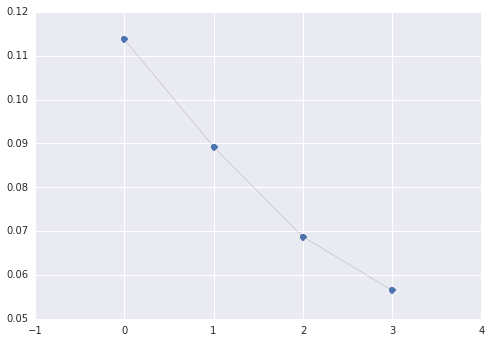

In [205]:
sns.tsplot(data=data.mean(), ci=[68], interpolate=False)

### Problem 2:

Problem 2 (Na¨ıve Bayes; 20 points). Download the “20 Newsgroups data set” news.mat from
Courseworks. The training feature vectors/labels and test feature vectors/labels are stored as
data/labels and testdata/testlabels. Each data point corresponds to a message posted to one
of 20 different newsgroups (i.e., message boards). The representation of a message is a (sparse)
binary vector in X := {0, 1}
d
(for d := 61188) that indicates the words that are present in the
message. 

If the j-th entry in the vector is 1, it means the message contains the word that is given
on the j-th line of the text file news.vocab. The class labels are Y := {1, 2, . . . , 20}, where the
mapping from classes to newsgroups is in the file news.groups (which we won’t actually need).
In this problem, you’ll develop a classifier based on a Na¨ıve Bayes generative model. Here, we
use class conditional distributions of the form
$$Pµ(x) = Y
d
j=1
µ
xj
j
(1 − µj )
1−xj
for x = (x1, x2, . . . , xd) ∈ X $$
for some parameter vector µ = (µ1, µ2, . . . , µd) ∈ [0, 1]d
. 

Since there are 20 classes, the generative
model is actually parameterized by 20 such vectors, µy = (µy,1, µy,2, . . . , µy,d) for each y ∈ Y, as
well as the class prior parameters, πy for each y ∈ Y. The class prior parameters, of course, must
satisfy πy ∈ [0, 1] for each y ∈ Y and P
y∈Y πy = 1.


(a) Give the formula for the MLE of the parameter µy,j based on training data {(xi
, yi)}
n
i=1.
(Remember, each unlabeled point is a vector: xi = (xi,1, xi,2, . . . , xi,d) ∈ {0, 1}
d
.)

(b) It turns out the MLE is not a good estimator for the class conditional parameters, especially if
the estimate turns out to be zero or one. An alternative to the MLE is the following estimator
based on a technique called Laplace smoothing:
$$µˆy,j :=
1 + Pn
i=1 1{yi = y}xi,j
2 + Pn
i=1 1{yi = y}$$
This ensures that ˆµy,j ∈ (0, 1)—never zero nor one.
Write a function that takes as input a (sparse) matrix of training feature vectors X and a
vector of labels Y (as data and labels above), and returns the parameters params of the
classifier based on this Na¨ıve Bayes generative model. Use the Laplace smoothing estimator
for the class conditional distribution parameters, and use MLE for the class prior parameters.
Naturally, you should not use or look at any existing implementation (e.g., such as those that
may be provided as library functions).
Also, write a function that takes as input the parameters of the above classifier params, and
a matrix of test feature vectors test. The function should output a vector of predictions
preds for all test feature vectors.
Train and evaluate a classifier using this code and the data from news.mat. Submit your
source code, and report the training and test error rates in your write-up. Save the learned
classifier for part (c)!

(c) The classifier you learn should have the following form: x 7→ arg maxy∈Y αy,0 +
Pd
j=1 αy,jxj
for some real numbers αy,0, αy,1, . . . , αy,d for each y ∈ Y. Compute the values of these αy,j ’s
from (the parameters of) your learned classifier from part (b).
For each class y ∈ Y, report the vocabulary words whose indices j ∈ {1, 2, . . . , d} correspond
to the 20 largest (i.e., most positive) αy,j value. Don’t report the j’s, but rather the actual
vocabulary words (from news.vocab).

In [207]:
news = loadmat('./data/news.mat')

In [572]:
# 7505 x 61188 sparse matrix
p2testdata = news['testdata']
# 7505 x 1 array
p2testlabels = news['testlabels']

# 11269 x 61188 sparse matrix
p2trainingdata = news['data'].toarray()
# 11269 x 1 array
p2traininglabels = news['labels']

In [439]:
# v = p2traininglabels
# breakpoints = np.where(v[:-1] != v[1:])[0]
# Boards = np.array(np.split(p2trainingdata.toarray(), breakpoints))
# mus = np.array([board.mean(axis=1) for board in Boards])
# smoothed_mus = np.array([(board.sum(axis=0) + 1) / (board.shape[0] + 2) for board in Boards])

In [581]:
def fit(X, Y, laplace=False):
    """ Create parameter weightings. """
    breakpoints = np.where(Y[:-1] != Y[1:])[0]
    Boards = np.array(np.split(X, breakpoints))
    if laplace:
        mus = np.array([(board.sum(axis=0) + 1) / (board.shape[0] + 2) for board in Boards])
    else: 
        mus = np.array([board.mean(axis=1) for board in Boards])
    
    return mus

In [591]:
def loglikelihoods(Mu, x):
    """ Computes the loglikelihod of a a vector for each class """
    return x.dot(np.log(Mu)) + (1-x).dot(np.log(1-Mu))

In [583]:
def posteriors(lls, prior):
    return lls * prior

In [606]:
loglikelihoods(smoothed_mus.T, test[0]).max()

-644.02392584808968

array([ 0.,  0.,  1., ...,  0.,  0.,  0.])

In [601]:
smoothed_mus.T.shape

(61188, 20)

In [538]:
priors = [(board.shape[0] / Boards.shape[0]) / 100 for board in Boards]

In [584]:
test = p2testdata.toarray()

In [590]:
hoods = np.apply_along_axis(loglikelihoods, 1, smoothed_mus, test)

In [587]:
posts = hoods.T * priors

In [610]:
np.argmax(posts, axis=1)

array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19,  6, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19])

In [ ]:
def predict(params, test, priors):
    likelihoods = np.apply_along_axis(loglikelihoods, 1, smoothed_mus, test[:100])
    posteriors = likelihoods
    
    return preds

#### Jetsam

In [ ]:
def group(lst, n):
  for i in range(0, len(lst), n):
    val = lst[i:i+n]
    if len(val) == n:
      yield tuple(val)

In [ ]:
dists = np.apply_along_axis(compute_distances, 1, testdata, trainingdata)

In [ ]:
training_datasets = {}
for n in [1000, 2000, 4000, 8000]:
    samples = []
    for sample in range(10):
        sel = random.sample(xrange(60000), n) 
        data = ocr['data'][sel]
        labels = ocr['labels'][sel]
        samples.append({'data':data, 'labels':labels})
    training_datasets[n] = samples

In [ ]:
def nn(ix, testdata, testlabels, training_data, training_labels):
    distances = compute_distances(testdata[ix], training_data)
    minima = np.argmin(distances)
    predicted_label = predict(minima, training_labels)
    actual_label = testlabels[ix][0]
    check_prediction(predicted_label, actual_label)